# Decision Analysis and Policy Evaluation

Up to this point, the analysis has focused on validating the predictive models from a statistical and behavioral perspective — including discrimination, calibration, interpretability, stability over time, and segment-level error analysis. Having established that the models behave in a consistent and sensible way, the purpose of this notebook is to shift the focus from model quality to decision impact. In other words, we now explore how model scores translate into concrete credit decisions and what trade-offs emerge when those scores are used to define approval policies.

This notebook will explore how approval rates, risk concentration, and loss proxies shift as we adjust score cut-offs, helping us understand how the portfolio’s composition changes when criteria are tightened or relaxed. Rather than making claims about absolute profitability or optimal decisions, the focus is on comparing how risk levels and volume distribution vary across score ranges and how different models behave when applied to the same approval context.

In [ ]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
from functions import performance_report, default_report

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
TARGET = "default_binary"
XGB_SCORE_COLUMN = "xgb_pred_calibrated"
LR_SCORE_COLUMN = "lr_pred_calibrated"

data = pd.read_parquet("../data/scored_calibrated_data.parquet")

train_data = data[data["dataset"] == "train"].copy()
validation_data = data[data["dataset"] == "validation"].copy()

# Understanding Current Policy

To begin, we’ll examine the dataset to interpret the decision policy currently implemented by the company. Applicant risk segmentation is based on the `loan_grade` and `loan_subgrade` features. By analyzing these groups, we can observe patterns in average loan amounts, interest rates, and the share of approved applicants across different risk bands.

For example, a much smaller population in the riskiest subgrades might point to stricter approval rules for high-risk applicants, even if these individuals are offered higher interest rates. On the other hand, seeing higher volumes or relatively favorable rates in certain subgrades could signal a targeted risk appetite or strategic business positioning. This analysis enables us to infer the logic of approval strategies, risk-based pricing patterns, and business rules that define the current lending approach. It also highlights whether the acceptance policy is applied consistently or if there is special caution in specific segments. Building on these insights, we can later link observed patterns to model-predicted scores and simulate the impact of changing approval policy.

In [ ]:
with pd.option_context("display.max_columns", None):
    summary = validation_data.groupby("loan_grade")[
        ["default_binary", "loan_amount_funded", "interest_rate"]
    ].mean()
    summary["count"] = validation_data.groupby("loan_grade").size()
    summary["default_binary"] = summary["default_binary"].map(lambda x: f"{x:.1%}")
    summary["interest_rate"] = summary["interest_rate"].map(lambda x: f"{x:.1%}")
    summary["loan_amount_funded"] = summary["loan_amount_funded"].map(lambda x: f"${x:,.0f}")

    display(summary.T)

    summary = validation_data.groupby("loan_subgrade")[
        ["default_binary", "loan_amount_funded", "interest_rate"]
    ].mean()
    summary["count"] = validation_data.groupby("loan_subgrade").size()
    summary["default_binary"] = summary["default_binary"].map(lambda x: f"{x:.1%}")
    summary["interest_rate"] = summary["interest_rate"].map(lambda x: f"{x:.1%}")
    summary["loan_amount_funded"] = summary["loan_amount_funded"].map(lambda x: f"${x:,.0f}")

    display(summary.T)

loan_grade,A,B,C,D,E,F,G
default_binary,4.6%,11.0%,18.5%,24.7%,29.0%,36.0%,38.6%
loan_amount_funded,"$13,918","$12,068","$12,370","$14,311","$13,173","$13,256","$17,279"
interest_rate,6.9%,10.5%,14.0%,18.2%,24.1%,29.4%,30.9%
count,10033,17051,13566,5328,1581,286,57


loan_subgrade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
default_binary,2.6%,4.2%,5.1%,5.2%,6.6%,8.6%,9.1%,11.2%,11.8%,13.6%,16.7%,17.8%,18.6%,20.1%,20.7%,23.5%,23.6%,24.6%,28.3%,41.0%,27.7%,29.1%,27.1%,30.0%,36.1%,33.3%,36.8%,30.8%,48.5%,41.4%,20.0%,33.3%,33.3%,100.0%,64.3%
loan_amount_funded,"$13,743","$13,822","$14,429","$14,743","$13,130","$12,479","$12,222","$11,814","$11,788","$11,955","$11,967","$11,754","$11,753","$13,474","$13,217","$14,016","$14,532","$14,793","$13,883","$13,864","$13,652","$13,085","$13,425","$11,474","$13,565","$12,342","$12,071","$12,442","$16,655","$16,667","$21,176","$12,556","$14,772","$19,450","$17,059"
interest_rate,5.3%,7.0%,7.2%,7.5%,8.0%,8.2%,10.5%,11.4%,11.4%,11.5%,12.7%,13.5%,14.0%,15.0%,16.0%,17.0%,18.0%,19.0%,20.0%,21.5%,22.7%,24.0%,24.7%,25.5%,26.2%,28.7%,29.5%,30.0%,30.5%,30.7%,30.8%,30.8%,30.9%,30.9%,31.0%
count,2727,1719,1625,1820,2142,4043,2631,2705,3096,4576,3828,2764,2272,2606,2096,1718,1570,1135,844,61,537,402,291,207,144,147,38,39,33,29,20,12,9,2,14


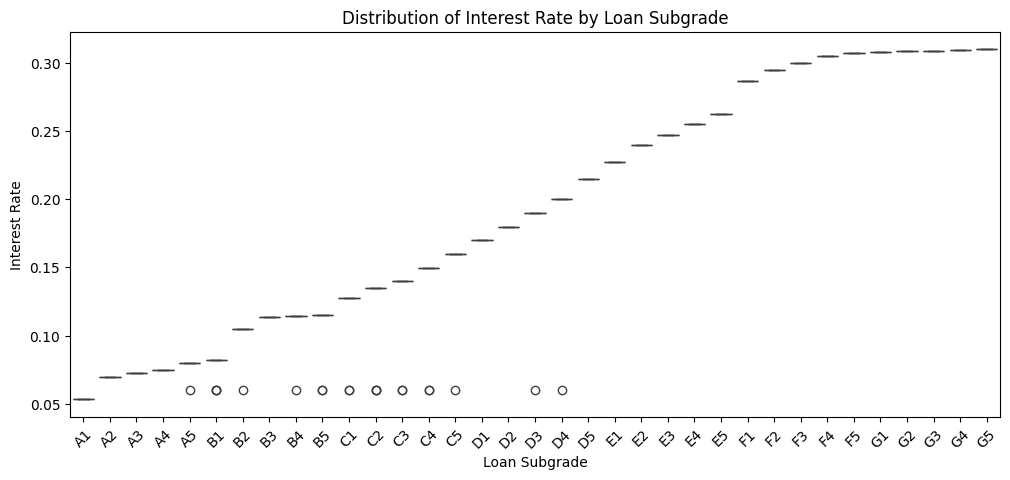

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=validation_data.sort_values("loan_subgrade"),
    x="loan_subgrade",
    y="interest_rate",
    order=sorted(validation_data["loan_subgrade"].unique()),
)
plt.title("Distribution of Interest Rate by Loan Subgrade")
plt.xlabel("Loan Subgrade")
plt.ylabel("Interest Rate")
plt.xticks(rotation=45)
plt.show()

The grade and subgrade breakdown reveals a very clear and economically intuitive pattern. As we move from safer to riskier bands, default rates increase monotonically, and this increase is closely matched by a stepwise rise in the interest rates charged. This strongly suggests that the company is operating under a risk-based pricing framework, where higher expected risk is explicitly compensated through higher rates rather than being addressed solely via rejection. In other words, acceptance and pricing appear to be jointly optimized, not treated as independent decisions. Also, there does not appear to be a consistent shift in the approved loan amount across risk bands, as funded loan amounts remain fairly stable in the 13–14k range for all grades. This indicates that lending limits are not being systematically adjusted alongside risk or pricing.

At the same time, volume distribution across grades provides important additional context. While interest rates continue to increase in the riskiest grades and subgrades, the number of approved loans drops sharply in these regions. This indicates that pricing alone is not the only control mechanism: there is also a clear approval filter that limits exposure to the highest-risk applicants. The very small counts observed in the worst subgrades (particularly in F and G) suggest that these segments may be deliberately kept thin, either due to internal risk limits, regulatory considerations, or to maintain optionality for future policy adjustments without materially impacting portfolio performance.

# Impact of Existing Credit Policy

At this point, it is important to recognize that the observed outcomes in this dataset are the result of an existing credit policy, not of a random sampling of applicants. The grade and subgrade distributions, combined with sharply decreasing volumes in the riskiest bands and increasing interest rates, strongly suggest that the data reflects a policy-conditioned population: applicants are first filtered by approval rules and then priced according to risk.

Because of this, directly comparing a new model’s score to observed defaults would be misleading. The realized default rates already embed at least two structural biases:
1. Approval bias: the riskiest applicants are partially or fully filtered out, especially in the worst subgrades.
2. Risk-based pricing effects: higher-risk borrowers face higher interest rates, which can itself influence repayment behavior and observed default rates.

To address this, the first step is to reconstruct a proxy for the current decision score implied by the existing policy. We do this by mapping each loan subgrade to its empirical default rate and treating this mapping as a baseline risk score. This allows us to translate the company’s categorical grading system into a continuous probability-like measure that reflects how risk is currently segmented and accepted in practice.

This reconstructed score does not represent an unbiased estimate of true applicant risk. Instead, it serves as a policy-consistent benchmark: a way to compare alternative models under the same approval and selection constraints. Only after anchoring the analysis to this baseline can we fairly evaluate lift, cumulative defaults, and portfolio composition changes when replacing or augmenting the current policy with a new model.

In the next steps, we will therefore:
- compare model scores against this policy-implied baseline rather than raw outcomes,
- analyze lift, cumulative default, and risk concentration under matched approval rates,
- and explicitly assess where differences come from improved ranking versus policy-induced bias.

This framing allows us to evaluate incremental model value while respecting the structural constraints imposed by the existing credit policy. 

In [ ]:
subgrade_default_map = train_data.groupby("loan_subgrade")[TARGET].mean().to_dict()
validation_data["current_score"] = validation_data["loan_subgrade"].map(subgrade_default_map)

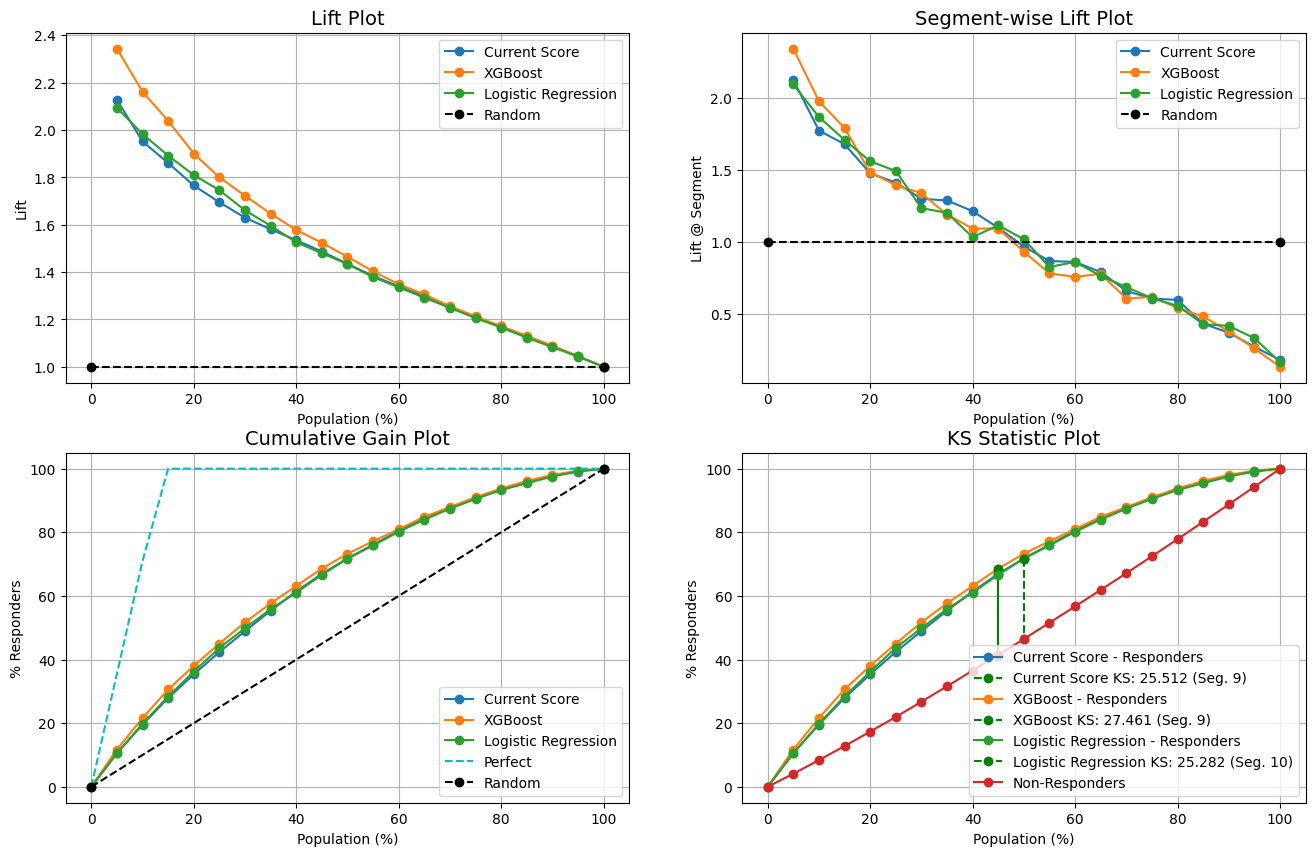

In [ ]:
models = {
    "Current Score": validation_data["current_score"],
    "XGBoost": validation_data[XGB_SCORE_COLUMN],
    "Logistic Regression": validation_data[LR_SCORE_COLUMN],
}

st = performance_report(validation_data[TARGET], models, labels=False, n_segments=20)

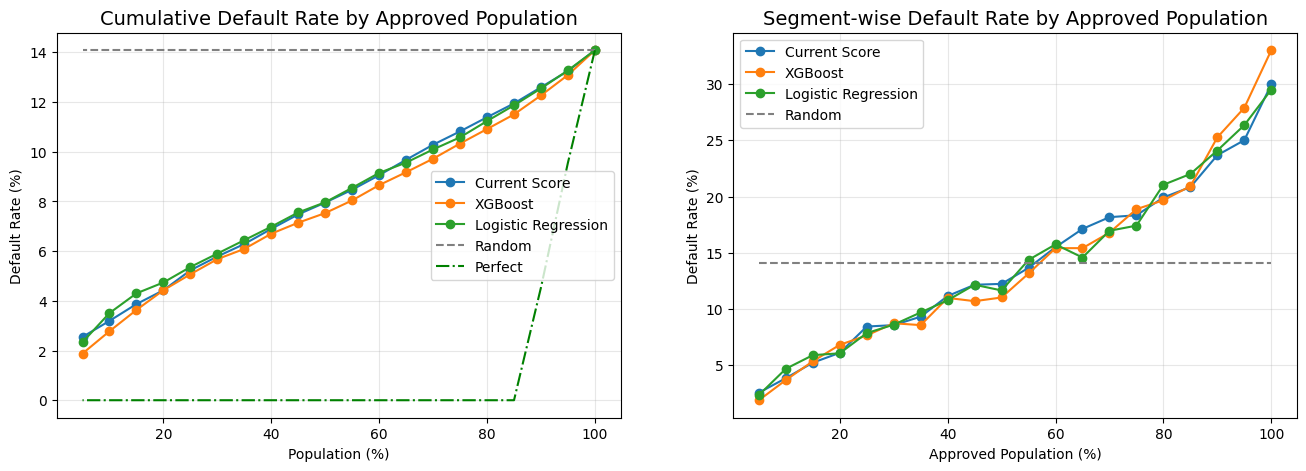

In [ ]:
st = default_report(validation_data[TARGET], models, labels=False, n_segments=20)

Looking at the lift, cumulative gains, KS, and cumulative default curves, the first conclusion is that all three scores — the inferred current policy score, logistic regression, and XGBoost — produce broadly similar ordering of risk within the approved population. XGBoost consistently delivers the strongest lift in the top segments and the highest KS statistic, followed closely by logistic regression, with the current policy score trailing slightly behind. This indicates that the alternative models are extracting additional discriminatory power from the same applicant information, even when evaluated on data that has already been shaped by an existing approval and pricing policy. Importantly, the separation gains are most visible in the early population percentiles, which is precisely where a credit granting model delivers the most business value.

At the same time, these results must be interpreted with caution. The evaluation sample is not policy-neutral: observed outcomes reflect a portfolio that has already been filtered by Lending Club’s approval rules and risk-based pricing strategy. High-risk applicants are underrepresented, and interest rates are explicitly correlated with subgrade, which in turn is correlated with default outcomes. As a result, the inferred "current score" and the newly trained models are not being compared on a fully counterfactual population. What these plots primarily tell us is that, conditional on the approved population, the new models provide a more efficient ranking of relative risk. A fairer comparison would require either restricting evaluation to regions of strong overlap between policies, applying rejection inference techniques, or framing the analysis as a policy simulation exercise (e.g., fixing approval volume or target default rate and comparing implied portfolios). This framing clarifies that the observed gains are incremental improvements within an existing policy regime, rather than a direct statement about absolute performance in a fully unconstrained decision setting.

# Dealing with Biases

## What the dataset does not contain
There are two critical elements that the dataset does not provide. First, we don't know if there is randomization in approval or pricing (probably not): interest rates are almost entirely determined by loan subgrade, which in turn is generated by the production scoring system. Second, there is no meaningful variation of pricing within subgrade. Because pricing directly affects borrower behavior and default outcomes, this endogeneity prevents a clean interpretation of observed risk improvements as direct monetary gains. In other words, while we can observe differences in risk ordering, we cannot directly translate these differences into expected profit or loss reductions without making additional assumptions. Any statement such as "a lift improvement of X implies a monetary gain of Y" would be unjustified with the available data.

## What would be required for a causal evaluation
In an ideal setting, this limitation would be addressed through randomized or exploratory data. The most straightforward solution would be randomized pricing experiments (or shadow pricing), where applicants with similar risk profiles are offered different interest rates, allowing direct estimation of price elasticity and its impact on default. Even limited randomization — for example, small pricing perturbations within subgrades or randomized pricing for marginal segments — would make it possible to disentangle latent risk from pricing effects and evaluate new models more causally. While full randomization in the highest-risk bands may be prohibitively expensive, partial experimentation in selected bands would already provide substantial value.

## A pragmatic path forward with assumption-driven adjustments
Given that such data is not available here, the most defensible path forward is to proceed with an explicitly assumption-driven adjustment, rather than treating observed defaults as immutable truths. One pragmatic approach is to assume a reasonable elasticity of default with respect to pricing, calibrated from external evidence or conservative internal benchmarks. Under this framework, when a new model reorders applicants across subgrades, individual risk estimates can be adjusted to reflect the expected default behavior under the pricing associated with the new subgrade, rather than the historical one. For example, if an applicant historically priced as E2 would be reclassified to B3 by a challenger model, their expected default rate should be adjusted toward the typical default level observed under B3 pricing. While this does not eliminate bias, it directly addresses the dominant pricing channel and yields a comparison that is substantially more coherent than using raw observed outcomes.

## Remaining bias: approval filters and swap symmetry
After applying such pricing-adjusted risk estimates, the remaining bias primarily relates to approval filters. Without randomized approvals, this cannot be fully resolved. A reasonable and commonly used assumption in this setting is swap symmetry: the marginal applicants swapped into approval by the new model are assumed to be statistically similar (in aggregate risk) to those swapped out by the old policy. This assumption is most defensible when gains are concentrated in middle to lower risk bands — as observed in the earlier analyses — rather than at the extreme tails. Under this assumption, portfolio-level comparisons become interpretable as incremental improvements around the existing policy frontier, rather than as wholesale regime changes.

## Pricing adjustment as an explicit modeling assumption

Here we do not attempt to recover fully causal counterfactual outcomes. Instead, we make pricing effects explicit by modeling only the mechanical affordability channel. This choice is deliberate. Given that interest rates are almost entirely determined by subgrade, any re-ranking of applicants across subgrades necessarily implies a change in pricing. Ignoring this channel would implicitly assume that default risk is invariant to payment burden, which is economically indefensible.

Because we lack fully randomized pricing data, we must take an explicitly assumption-driven approach: we posit how risk responds to pricing changes, allowing us to proceed transparently and consistently with our analysis. Specifically, we define an adjusted score as follows:
$$\text{score}_{\text{adjusted}}
=
f\big(
\text{score}_{\text{model}},
 g_{\text{old}},
 g_{\text{new}}
\big)$$

where the adjustment operates exclusively through the implied change in payment burden associated with the subgrade transition.

## Step A — Mapping subgrades to payment burden
For each loan subgrade ( $g$ ), we estimate a representative interest rate ( $r_g$ ), for example the median observed `interest_rate` within that subgrade. Loan maturity ( $T$ ) is taken from the observed `loan_term_months` (36 here) and can be handled at the individual-loan level.
Given loan amount ( $L$ ), the monthly payment of a fully amortizing loan is approximated by:
$$
\text{PMT}(r, T, L)= 
L \cdot
\frac{i(1+i)^T}{(1+i)^T - 1},
\qquad
i = \frac{r}{12}$$
When an applicant is reassigned from an original subgrade ( $g_{\text{old}}$ ) to a new subgrade ( $g_{\text{new}}$ ), we quantify the pricing shock as the relative change in monthly payment:
$$
\Delta \log \text{PMT}
=
\log\left(
\frac{\text{PMT}(r_{g_{\text{new}}}, T, L)}
{\text{PMT}(r_{g_{\text{old}}}, T, L)}
\right)
$$

This quantity is positive when the new pricing implies higher payments and negative when pricing becomes more favorable. By working in relative (log) terms, the adjustment is naturally scale-free and comparable across loan sizes and maturities.

## Step B — Adjusting default risk via payment elasticity

Default risk is adjusted in log-odds space, using an explicit elasticity that links proportional changes in payment burden to proportional changes in default odds:
$$
\text{logit}\left(PD_{\text{adjusted}}\right)
=
\text{logit}\left(PD_{\text{model}}\right)
+
\beta_{\text{pmt}} \cdot \Delta \log \text{PMT}
$$

Where:

* $PD_{\text{model}}$ is the raw predicted default probability from the challenger model,
* $\beta_{\text{pmt}}$ is the elasticity of default odds with respect to payment burden.

This formulation is intentionally simple, monotonic, and transparent. It preserves the relative ordering produced by the model while shifting risk levels in a way that is economically interpretable and suitable for governance review.

## Choice of elasticity $\beta_{\text{pmt}}$

Because the dataset contains no pricing randomization, $\beta_{\text{pmt}}$ cannot be estimated internally and must be treated as an explicit modeling assumption.

Empirical evidence from the consumer credit literature — including studies of interest-rate resets, refinancing shocks, and payment relief programs — consistently shows that, in the US, higher required payments increase delinquency and default, even holding borrower characteristics constant. Translating these findings into a parsimonious log-odds framework suggests a conservative and defensible range:


$$\beta_{\text{pmt}} \in [1.0,2.0]$$


Interpretation: a 10% increase in monthly payment implies an increase in default odds of approximately 10%–22%, since


$$\exp\left(\beta_{\text{pmt}} \cdot \log(1.1)\right)$$


falls within this interval for $\beta_{\text{pmt}} \in [1,2]$. This magnitude is economically plausible for unsecured personal loans and directly tied to the affordability channel, rather than behavioral or selection effects.

In this analysis, we adopt $\beta_{\text{pmt}} = 1.5$ as an intermediate and reasonable value within this range.

In [ ]:
BETA_PMT_LIST = [1.0, 2.0]
EPS = 1e-12


def logit(p):
    p = np.clip(p, EPS, 1 - EPS)
    return np.log(p / (1 - p))


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

The first step is to create the new subgrade columns. We will use the same proportions as before, without any changes, as mentioned earlier.

In [ ]:
subgrades_lc = [
    "A1",
    "A2",
    "A3",
    "A4",
    "A5",
    "B1",
    "B2",
    "B3",
    "B4",
    "B5",
    "C1",
    "C2",
    "C3",
    "C4",
    "C5",
    "D1",
    "D2",
    "D3",
    "D4",
    "D5",
    "E1",
    "E2",
    "E3",
    "E4",
    "E5",
    "F1",
    "F2",
    "F3",
    "F4",
    "F5",
    "G1",
    "G2",
    "G3",
    "G4",
    "G5",
]
n_subgrades = len(subgrades_lc)

# Get empirical subgrade proportions from the training data, ensuring they align with the correct order
subgrade_props = train_data["loan_subgrade"].value_counts(normalize=True).reindex(subgrades_lc)
cumulative_props = np.append([0], np.cumsum(subgrade_props.values))


def assign_subgrades_by_proportions(train_df, target_col, out_col_prefix, application_dfs):
    """
    Assigns subgrade labels to provided dataframes using quantile bins
    based on the *empirical proportions* of original subgrades in train_df['loan_subgrade'].

    Parameters
    ----------
    train_df : pd.DataFrame
        DataFrame to use for fitting quantile edges.
    target_col : str
        The name of the PD/score column to assign with.
    out_col_prefix : str
        Output column will be f'loan_subgrade_{out_col_prefix}'.
    application_dfs : list
        List of DataFrames to assign subgrades to (in-place).
    """

    pd_values = train_df[target_col].values.copy()
    quantile_thresholds = np.quantile(pd_values, cumulative_props)

    def scores_to_subgrade_labels(pd_scores):
        idx = np.searchsorted(quantile_thresholds, pd_scores, side="right") - 1
        idx = np.clip(idx, 0, n_subgrades - 1)
        return np.array(subgrades_lc)[idx]

    for df in application_dfs:
        df[f"loan_subgrade_{out_col_prefix}"] = scores_to_subgrade_labels(df[target_col].values)


# Assign for XGB (by new subgrade proportions)
assign_subgrades_by_proportions(
    train_data,
    target_col="xgb_pred_calibrated",
    out_col_prefix="xgb",
    application_dfs=[train_data, validation_data],
)

# Assign for LR (by new subgrade proportions)
assign_subgrades_by_proportions(
    train_data,
    target_col="lr_pred_calibrated",
    out_col_prefix="lr",
    application_dfs=[train_data, validation_data],
)

In [ ]:
# 1) Map subgrade -> representative rate r_g (median in train)
subgrade_rate_map = train_data.groupby("loan_subgrade")["interest_rate"].median()

# For XGB
for df in (train_data, validation_data):
    df["r_old_xgb"] = df["loan_subgrade"].map(subgrade_rate_map)
    df["r_new_xgb"] = df["loan_subgrade_xgb"].map(subgrade_rate_map)
    df["r_new_xgb"] = df["r_new_xgb"].fillna(df["r_old_xgb"])

# For LR
for df in (train_data, validation_data):
    df["r_old_lr"] = df["loan_subgrade"].map(subgrade_rate_map)
    df["r_new_lr"] = df["loan_subgrade_lr"].map(subgrade_rate_map)
    df["r_new_lr"] = df["r_new_lr"].fillna(df["r_old_lr"])

validation_data[["interest_rate", "r_old_xgb", "r_new_xgb", "r_old_lr", "r_new_lr"]].head()

,interest_rate,r_old_xgb,r_new_xgb,r_old_lr,r_new_lr
942105,0.0749,0.0749,0.0799,0.0749,0.0839
942106,0.1144,0.1099,0.0699,0.1099,0.0749
942107,0.0699,0.0649,0.0949,0.0649,0.0749
942108,0.1139,0.1049,0.0649,0.1049,0.0649
942109,0.0699,0.0649,0.0532,0.0649,0.0649


In [ ]:
# 2) Compute payment burden shock: Δ log PMT
# PMT(L, r, T) = L * i * (1+i)^T / ((1+i)^T - 1),  i = r/12
def pmt(amount, rate_annual, term_months):
    i = rate_annual / 12.0
    T = term_months

    # Handle zero/near-zero rates safely
    # If i ~ 0, PMT ~ L/T
    near_zero = np.isclose(i, 0.0)
    out = np.empty_like(amount, dtype=float)

    # Standard amortization
    i_nz = np.where(near_zero, 1e-9, i)
    pow_ = np.power(1.0 + i_nz, T)
    out_std = amount * (i_nz * pow_) / (pow_ - 1.0)

    # Zero-rate approximation
    out_zero = amount / np.clip(T, 1.0, None)

    out = np.where(near_zero, out_zero, out_std)
    return out


for df in (train_data, validation_data):
    L = df["loan_amount_funded"].astype(float).to_numpy()
    T = df["loan_term_months"].astype(float).to_numpy()
    # For XGB rates
    pmt_old_xgb = pmt(L, df["r_old_xgb"].astype(float).to_numpy(), T)
    pmt_new_xgb = pmt(L, df["r_new_xgb"].astype(float).to_numpy(), T)
    df["pmt_old_xgb"] = pmt_old_xgb
    df["pmt_new_xgb"] = pmt_new_xgb
    df["pmt_ratio_xgb"] = np.clip(pmt_new_xgb, EPS, None) / np.clip(pmt_old_xgb, EPS, None)
    df["delta_log_pmt_xgb"] = np.log(np.clip(pmt_new_xgb, EPS, None) / np.clip(pmt_old_xgb, EPS, None))
    # For LR rates
    pmt_old_lr = pmt(L, df["r_old_lr"].astype(float).to_numpy(), T)
    pmt_new_lr = pmt(L, df["r_new_lr"].astype(float).to_numpy(), T)
    df["pmt_old_lr"] = pmt_old_lr
    df["pmt_new_lr"] = pmt_new_lr
    df["pmt_ratio_lr"] = np.clip(pmt_new_lr, EPS, None) / np.clip(pmt_old_lr, EPS, None)
    df["delta_log_pmt_lr"] = np.log(np.clip(pmt_new_lr, EPS, None) / np.clip(pmt_old_lr, EPS, None))

validation_data[
    [
        "interest_rate",
        "r_old_xgb",
        "r_new_xgb",
        "pmt_old_xgb",
        "pmt_new_xgb",
        "pmt_ratio_xgb",
        "delta_log_pmt_xgb",
        "r_old_lr",
        "r_new_lr",
        "pmt_old_lr",
        "pmt_new_lr",
        "pmt_ratio_lr",
        "delta_log_pmt_lr",
    ]
].head()

,interest_rate,r_old_xgb,r_new_xgb,pmt_old_xgb,pmt_new_xgb,pmt_ratio_xgb,delta_log_pmt_xgb,r_old_lr,r_new_lr,pmt_old_lr,pmt_new_lr,pmt_ratio_lr,delta_log_pmt_lr
942105,0.0749,0.0749,0.0799,311.016257,313.317525,1.007399,0.007372,0.0749,0.0839,311.016257,315.165917,1.013342,0.013254
942106,0.1144,0.1099,0.0699,425.541762,401.342824,0.943134,-0.058547,0.1099,0.0749,425.541762,404.321134,0.950133,-0.051154
942107,0.0699,0.0649,0.0949,92.699466,96.885533,1.045157,0.044168,0.0649,0.0749,92.699466,94.082418,1.014919,0.014808
942108,0.1139,0.1049,0.0649,292.479556,275.800063,0.942972,-0.058719,0.1049,0.0649,292.479556,275.800063,0.942972,-0.058719
942109,0.0699,0.0649,0.0532,367.733418,361.377375,0.982716,-0.017435,0.0649,0.0649,367.733418,367.733418,1.000000,0.000000


Since the index is in logarithmic scale, Δ log PMT approximately represents the percentage change in the installment value. For example, a Δ log PMT of 0.043 corresponds to about a 4.3% increase in payment.

In [ ]:
# 3) Adjust PD in log-odds space for both XGB and LR
# logit(PD_adj) = logit(PD_model) + beta_pmt * Δ log PMT
beta = 1.5
for df in (train_data, validation_data):
    # For XGBoost
    base_pd_xgb = df["xgb_pred_calibrated"].astype(float).to_numpy()
    z_xgb = logit(base_pd_xgb) + beta * df["delta_log_pmt_xgb"].astype(float).to_numpy()
    df["xgb_score_adjusted"] = sigmoid(z_xgb)
    # For Logistic Regression
    base_pd_lr = df["lr_pred_calibrated"].astype(float).to_numpy()
    z_lr = logit(base_pd_lr) + beta * df["delta_log_pmt_lr"].astype(float).to_numpy()
    df["lr_score_adjusted"] = sigmoid(z_lr)

validation_data[
    [
        "r_old_xgb",
        "r_new_xgb",
        "xgb_pred_calibrated",
        "xgb_score_adjusted",
        "r_old_lr",
        "r_new_lr",
        "lr_pred_calibrated",
        "lr_score_adjusted",
    ]
].head()

,r_old_xgb,r_new_xgb,xgb_pred_calibrated,xgb_score_adjusted,r_old_lr,r_new_lr,lr_pred_calibrated,lr_score_adjusted
942105,0.0749,0.0799,0.067742,0.068444,0.0749,0.0839,0.080399,0.081881
942106,0.1099,0.0699,0.044636,0.041037,0.1099,0.0749,0.055348,0.051470
942107,0.0649,0.0949,0.094412,0.100231,0.0649,0.0749,0.055348,0.056521
942108,0.1049,0.0649,0.024311,0.022307,0.1049,0.0649,0.044709,0.041095
942109,0.0649,0.0532,0.023703,0.023105,0.0649,0.0649,0.041940,0.041940


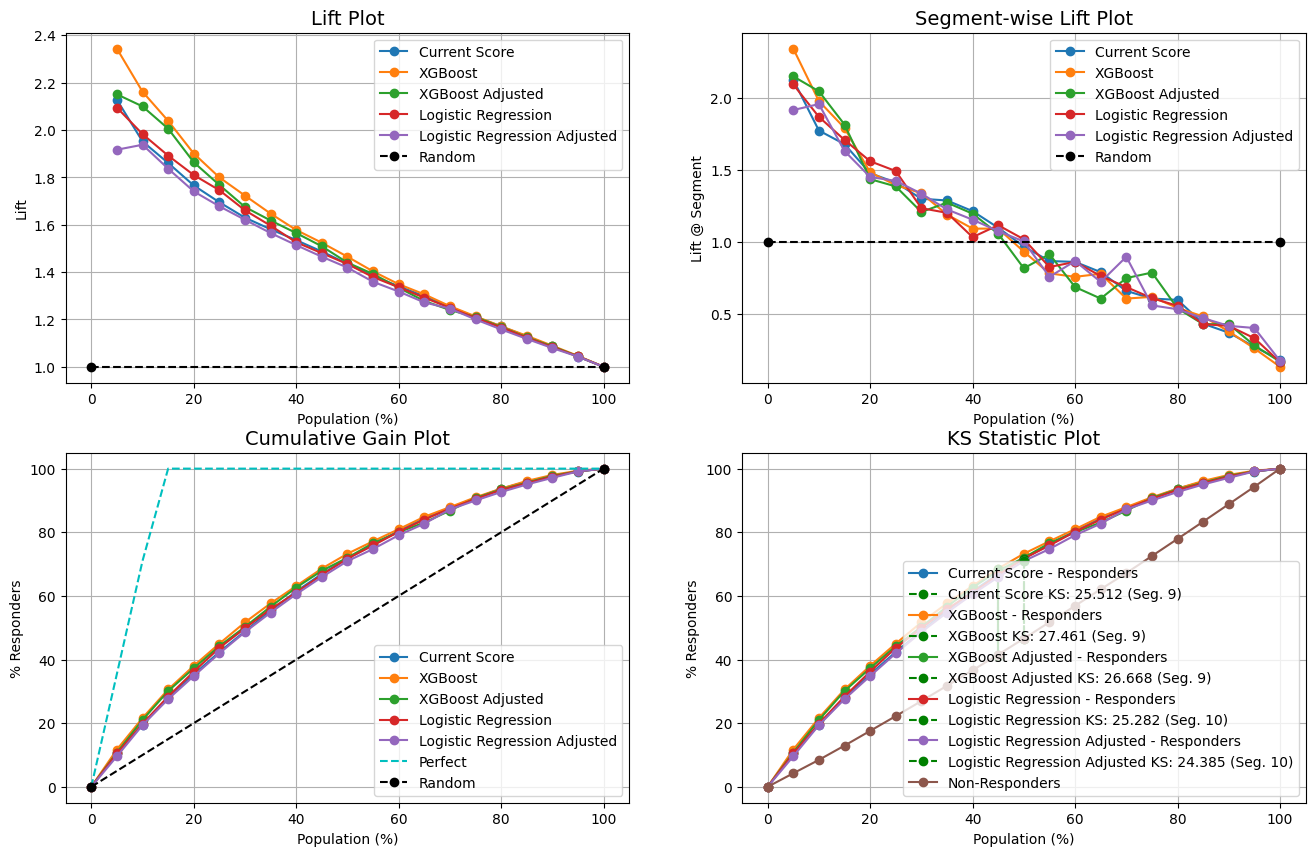

In [ ]:
models = {
    "Current Score": validation_data["current_score"],
    "XGBoost": validation_data[XGB_SCORE_COLUMN],
    "XGBoost Adjusted": validation_data["xgb_score_adjusted"],
    "Logistic Regression": validation_data[LR_SCORE_COLUMN],
    "Logistic Regression Adjusted": validation_data["lr_score_adjusted"],
}

st = performance_report(validation_data[TARGET], models, labels=False, n_segments=20)

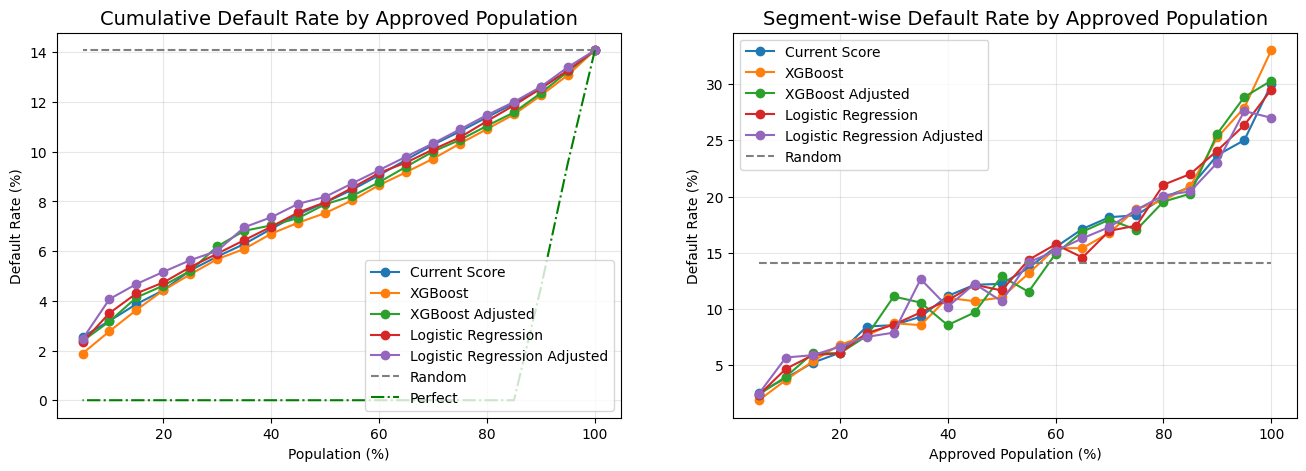

In [ ]:
st = default_report(validation_data[TARGET], models, labels=False, n_segments=20)

## Intuition behind the adjustment

What happens mechanically is simple. Borrowers originally in subgrade X exhibit a default rate that reflects both their latent risk and the pricing of band X. When the model moves them to subgrade Y, they no longer behave like “X borrowers” — they behave like Y-priced borrowers. If Y implies a higher interest rate, monthly payments increase, affordability worsens, and default risk shifts toward the average risk observed under Y pricing, even if the borrower is intrinsically safer. Conversely, downward moves benefit from lower payment burden. The adjustment replaces the illusion of fixed behavior with the economically consistent assumption that pricing shapes outcomes.

## Conclusions

Once pricing is made explicit, the apparent gap between XGBoost and Logistic Regression narrows substantially. In the raw view, XGBoost shows higher lift and KS by reordering risk under historical pricing. After adjustment, both models converge to similar performance, with XGBoost retaining a small but consistent edge in mid-risk segments, while Logistic Regression becomes slightly more conservative at the tails. This indicates that most of the original gain was incremental and concentrated around the existing approval frontier, rather than a wholesale improvement in portfolio quality.

From a decision perspective, the pricing-adjusted results are the relevant ones. They suggest that deploying XGBoost would yield modest, localized improvements. The models are therefore closer substitutes than raw lift curves would suggest, and any deployment case should be framed as a controlled upgrade rather than a step-change.

In [ ]:
def add_rate_means(st_table, score_series, rate_series):
    st_out = st_table.copy()
    means = []
    for _, row in st_out.iterrows():
        mask = (score_series >= row["probability_min"]) & (score_series < row["probability_max"])
        means.append(round(rate_series[mask].mean() * 100, 3))
    st_out["interest_rate_mean"] = means
    return st_out


st_xgb_adj = add_rate_means(
    st["XGBoost Adjusted"],
    validation_data["xgb_score_adjusted"],
    validation_data["r_new_xgb"],
)

cols = [
    "segment",
    "probability_min",
    "probability_max",
    "count",
    "segment_default_rate",
    "interest_rate_mean",
]
display(st_xgb_adj[cols].rename(columns={"interest_rate_mean": "interest_rate_mean_xgb"}))

,segment,probability_min,probability_max,count,segment_default_rate,interest_rate_mean_xgb
0,1,0.311,0.734,2396,30.301,20.468
1,2,0.277,0.311,2395,28.852,18.116
2,3,0.232,0.277,2395,25.595,16.774
3,4,0.208,0.232,2395,20.251,15.348
4,5,0.189,0.208,2395,19.541,14.577
5,6,0.174,0.189,2395,17.035,13.672
6,7,0.164,0.174,2395,17.954,13.225
7,8,0.153,0.164,2395,16.868,12.876
8,9,0.125,0.153,2395,14.906,11.908
9,10,0.116,0.125,2395,11.524,11.223


The segments of the adjusted score align closely with pricing tiers: at the top, we see average interest rates near 20% and default rates around 30%, which then decrease almost monotonically down to ~5–7% interest and ~2–4% default rates for the lowest-risk segments. Minor discontinuities (e.g., segments 7, 11, and 14) are due to quantile noise rather than true inversions in ranking. This confirms that, by reassigning subgrades, the adjusted model already embeds a pricing policy that is consistent with the risk ranking.

Uma boa estratégia a partir daqui que costuma facilitar a comunicação para pessoas não-técnicas, ou pelo menos que não são da área de dados, seria o de determinar o retorno financeiro dessa mudança, i.e. se mudarmos o modelo (ou a política), o que deveríamos esperar de retorno financeiro? Com a taxa de juros, o risco esperado e o valor que a empresa perderia caso o pagamento não fosse realizado. Antes de tudo, precisamos saber que a fórmula usada foi: amortização por prestação fixa, com taxa nominal anual em interest_rate representando a taxa ao ano, capitalizada mensalmente (i = interest_rate/12 por mês), em 36 meses.

In [ ]:
# Example of adjustment of the calculation, only to illustrate
example = train_data[["loan_amount_funded", "interest_rate", "monthly_payment"]].copy()
n_parcelas = 36
example["PMT_example"] = pmt(
    example["loan_amount_funded"],
    example["interest_rate"],
    example["loan_amount_funded"].apply(lambda x: n_parcelas),
)
example["total_payment_example"] = example["PMT_example"] * n_parcelas
example.head()

,loan_amount_funded,interest_rate,monthly_payment,PMT_example,total_payment_example
0,5000.0,0.1065,162.87,162.866094,5863.179392
1,2400.0,0.1596,84.33,84.329492,3035.861695
2,10000.0,0.1349,339.31,339.304507,12214.962270
3,5000.0,0.0790,156.46,156.451270,5632.245717
4,3000.0,0.1864,109.43,109.422782,3939.220136


In [ ]:
TERM_MONTHS = 36


def compute_lgd_by_segment(st_table, score_series, amount_series, payments_received, default_series):
    lgd_by_segment = {}

    for _, row in st_table.iterrows():
        mask = (score_series >= row["probability_min"]) & (score_series < row["probability_max"])
        mask_default = mask & (default_series == 1)
        amt = amount_series[mask_default].astype(float)
        pmt = payments_received[mask_default].astype(float)
        if len(amt) > 0:
            lgd = 1 - (pmt / amt).mean()
        else:
            lgd = 0.0
        lgd_by_segment[row["segment"]] = lgd
    return lgd_by_segment


def compute_rar_raroc(
    st_table,
    score_series,
    rate_series,
    amount_series,
    payments_received,
    default_series,
    term_months=TERM_MONTHS,
    capital_charge_rate=0.08,
):
    out = st_table.copy()
    rar_list, raroc_list = [], []
    repay_total_list, rate_mean_list, amount_mean_list = [], [], []
    capital_list = []

    n = term_months

    lgd_by_segment = compute_lgd_by_segment(
        st_table, score_series, amount_series, payments_received, default_series
    )

    for _, row in out.iterrows():
        mask = (score_series >= row["probability_min"]) & (score_series < row["probability_max"])
        rates = rate_series[mask].astype(float)
        amounts = amount_series[mask].astype(float)

        r = rates.mean()
        r = r / 100 if r > 1 else r
        pd_seg = row["segment_default_rate"] / 100
        amt_mean = amounts.mean()

        pmt_val = pmt(amt_mean, r, n)
        repay_total = pmt_val * n
        gross_profit = repay_total - amt_mean

        segment_lgd = lgd_by_segment[row["segment"]]
        expected_loss = pd_seg * segment_lgd * amt_mean

        # Calculation of Economic Capital (simplified)
        capital_economico = amt_mean * capital_charge_rate

        # RAR (Risk-Adjusted Return)
        rar = (gross_profit - expected_loss) / amt_mean if amt_mean else 0.0

        # RAROC (Risk-Adjusted Return on Capital)
        raroc = (gross_profit - expected_loss) / capital_economico if capital_economico else 0.0

        rate_mean_list.append(r)
        amount_mean_list.append(amt_mean)
        repay_total_list.append(repay_total)
        capital_list.append(capital_economico)
        rar_list.append(rar)
        raroc_list.append(raroc)

    out["rate_mean_frac"] = rate_mean_list
    out["loan_amount_mean"] = amount_mean_list
    out["repay_total_mean"] = repay_total_list
    out["capital_economico"] = capital_list
    out["rar"] = rar_list
    out["raroc"] = raroc_list

    return out


rar_xgb = compute_rar_raroc(
    st_xgb_adj,
    validation_data["xgb_score_adjusted"],
    validation_data["r_new_xgb"],
    validation_data["loan_amount_funded"],
    validation_data["total_payments_received"],
    validation_data["default_binary"],
)

display(rar_xgb[["segment", "rate_mean_frac", "segment_default_rate", "repay_total_mean", "rar", "raroc"]])

,segment,rate_mean_frac,segment_default_rate,repay_total_mean,rar,raroc
0,1,0.204683,30.301,20257.982118,0.161957,2.024463
1,2,0.181156,28.852,17751.830068,0.127665,1.595812
2,3,0.167739,25.595,17494.249050,0.118530,1.481622
3,4,0.153482,20.251,16212.309506,0.129494,1.618671
4,5,0.145771,19.541,15374.670545,0.119726,1.496577
5,6,0.136720,17.035,15426.558382,0.121521,1.519015
6,7,0.132251,17.954,15041.568874,0.105119,1.313990
7,8,0.128763,16.868,15048.272746,0.108554,1.356929
8,9,0.119085,14.906,14985.609226,0.103514,1.293922
9,10,0.112232,11.524,14426.934517,0.110347,1.379334


In [ ]:
EPS = 1e-12


def amort_schedule(amount: float, rate_annual: float, term_months: int):
    """
    Build an amortization schedule for a fixed-rate installment loan.
    Returns:
      bal_begin[t], interest[t], principal[t], bal_end[t], pay
    for t=0..term_months-1 (each index is a month).
    """
    i = rate_annual / 12.0
    pay = pmt(amount, rate_annual, term_months)

    bal_begin = np.zeros(term_months, dtype=float)
    interest = np.zeros(term_months, dtype=float)
    principal = np.zeros(term_months, dtype=float)
    bal_end = np.zeros(term_months, dtype=float)

    bal = float(amount)
    for t in range(term_months):
        bal_begin[t] = bal
        interest[t] = bal * i
        principal[t] = max(pay - interest[t], 0.0)
        bal = max(bal - principal[t], 0.0)
        bal_end[t] = bal

    return bal_begin, interest, principal, bal_end, pay


def irr_monthly(cashflows):
    """
    Compute monthly IRR from a list of cashflows [CF0, CF1, ..., CFn].
    Tries numpy_financial first; otherwise uses a bisection fallback.
    """
    lo, hi = -0.999, 10.0
    for _ in range(100):
        mid = (lo + hi) / 2.0
        npv = 0.0
        for t, cf in enumerate(cashflows):
            npv += cf / ((1.0 + mid) ** t)
        # If NPV positive, rate is too low
        if npv > 0:
            lo = mid
        else:
            hi = mid
    return (lo + hi) / 2.0


def irr_annual_from_monthly(r_m: float) -> float:
    return (1.0 + r_m) ** 12 - 1.0


def compute_p2p_lending_metrics(
    st_table: pd.DataFrame,
    score_series: pd.Series,
    amount_series: pd.Series,
    payments_received: pd.Series,
    default_series: pd.Series,
    term_months: int = 36,
    capital_charge_rate: float = 0.01,  # P2P: minimal capital immobilization
    opex_rate: float = 0.005,  # includes all costs (your assumption)
    global_lgd: float = 0.60,
    pd_is_percent: bool = True,  # segment_default_rate stored in %
):
    """
    Returns a per-segment table with:
      - irr_expected_annual: investor metric (cashflow-based expected IRR)
      - expected_profit_annual: platform / unit-economics profit (per loan per year)
      - roa_on_avg_balance: profit / average outstanding balance (amortization-correct)
      - raroc_annual: profit / capital (capital-light in P2P, so tends to be high)
    A fixed (global) LGD is applied for all segments.
    """

    lgd_global = float(np.clip(global_lgd, 0.0, 1.0))

    rows = []

    # Basic sanity check (optional but useful)
    score_min, score_max = float(score_series.min()), float(score_series.max())
    pmin, pmax = float(st_table["probability_min"].min()), float(st_table["probability_max"].max())

    for _, row in st_table.iterrows():
        # membership based on st_table boundaries
        mask = (score_series >= row["probability_min"]) & (score_series < row["probability_max"])
        amounts = amount_series[mask].astype(float)
        seg_count = float(row["count"])

        amt = float(amounts.mean()) if len(amounts) > 0 else 0.0
        if amt <= 0:
            continue

        # segment APR (from your table)
        r = float(row["interest_rate_mean"])
        r = r / 100.0 if r > 1.0 else r

        # PD (life) from st_table
        pd_life = float(row["segment_default_rate"])
        if pd_is_percent:
            pd_life = pd_life / 100.0
        pd_life = float(np.clip(pd_life, 0.0, 1.0))

        lgd = lgd_global

        # amortization schedule for the "average loan" in the segment
        bal_begin, interest_m, principal_m, bal_end, pay = amort_schedule(amt, r, term_months)
        avg_balance = float(bal_begin.mean())

        # gross interest (life + annualized)
        gross_interest_life = float(interest_m.sum())
        gross_interest_annual = gross_interest_life / (term_months / 12.0)

        # opex (life + annualized) following your assumption
        opex_life = float(opex_rate * amt)
        opex_annual = opex_life / (term_months / 12.0)

        # Convert life PD to constant monthly hazard (simplifying assumption)
        if pd_life <= 0:
            h = 0.0
        elif pd_life >= 1:
            h = 1.0
        else:
            h = 1.0 - (1.0 - pd_life) ** (1.0 / term_months)

        # Survival to month t (0-index t): S_t = (1-h)^t
        survival = np.array([(1.0 - h) ** t for t in range(term_months)], dtype=float)
        # Default in month t: S_t * h
        default_prob = survival * h

        # Expected loss uses exposure-at-default ~ balance at start of month
        expected_loss_life = float((default_prob * (lgd * bal_begin)).sum())
        expected_loss_annual = expected_loss_life / (term_months / 12.0)

        # Expected payments received (receive installment if alive at month start)
        expected_payments_life = float((survival * pay).sum())

        # Profit proxy over life (unit economics)
        expected_profit_life = expected_payments_life - amt - expected_loss_life - opex_life
        expected_profit_annual = expected_profit_life / (term_months / 12.0)

        # ROA on avg balance (amortization-correct)
        roa_on_avg_balance = expected_profit_annual / (avg_balance + EPS)

        # Capital & RAROC (platform view)
        capital = float(capital_charge_rate * amt)
        raroc_annual = expected_profit_annual / (capital + EPS)

        # Investor metric: expected IRR from expected monthly cashflows
        opex_month = opex_life / term_months
        cfs = [-amt]
        for t in range(term_months):
            cf_t = survival[t] * pay - default_prob[t] * (lgd * bal_begin[t]) - opex_month
            cfs.append(float(cf_t))

        irr_m = irr_monthly(cfs)
        irr_a = irr_annual_from_monthly(irr_m)

        rows.append(
            {
                "segment": row["segment"],
                "rate_mean_frac": r,
                "pd_life": pd_life,
                "lgd_estimated": lgd,
                "loan_amount_mean": amt,
                "avg_outstanding_balance": avg_balance,
                "gross_interest_annual_mean": gross_interest_annual,
                "expected_loss_annual_mean": expected_loss_annual,
                "opex_annual_mean": opex_annual,
                "expected_profit_annual": expected_profit_annual,
                "roa_on_avg_balance": roa_on_avg_balance,
                "capital_charge_rate": capital_charge_rate,
                "raroc_annual": raroc_annual,
                "irr_expected_annual": irr_a,
                "profit_total_per_year": expected_profit_annual * seg_count,
            }
        )

    return pd.DataFrame(rows)


global_lgd = 0.4

p2p_xgb = compute_p2p_lending_metrics(
    st_table=st_xgb_adj,
    score_series=validation_data["xgb_score_adjusted"],
    amount_series=validation_data["loan_amount_funded"],
    payments_received=validation_data["total_payments_received"],
    default_series=validation_data["default_binary"],
    term_months=36,
    capital_charge_rate=0.01,  # P2P assumption (1% capital)
    opex_rate=0.001,  # your assumption (all-in costs)
    global_lgd=global_lgd,
    pd_is_percent=True,  # segment_default_rate is in %
)

df_display = p2p_xgb[
    [
        "segment",
        "rate_mean_frac",
        "pd_life",
        "lgd_estimated",
        "loan_amount_mean",
        "avg_outstanding_balance",
        "gross_interest_annual_mean",
        "expected_loss_annual_mean",
        "opex_annual_mean",
        "expected_profit_annual",
        "roa_on_avg_balance",
        "irr_expected_annual",
        "capital_charge_rate",
        "raroc_annual",
        "profit_total_per_year",
    ]
].copy()

# percent formatting
pct_cols = ["rate_mean_frac", "pd_life", "lgd_estimated", "roa_on_avg_balance", "irr_expected_annual"]
for c in pct_cols:
    df_display[c] = df_display[c].apply(lambda x: f"{x:.1%}")

# money formatting
money_cols = [
    "loan_amount_mean",
    "avg_outstanding_balance",
    "gross_interest_annual_mean",
    "expected_loss_annual_mean",
    "opex_annual_mean",
    "expected_profit_annual",
    "profit_total_per_year",
]
for c in money_cols:
    df_display[c] = df_display[c].apply(lambda x: f"${x:,.0f}")

# raroc formatting
df_display["raroc_annual"] = df_display["raroc_annual"].apply(lambda x: f"{x:.3f}")

# capital charge formatting
df_display["capital_charge_rate"] = df_display["capital_charge_rate"].apply(lambda x: f"{x:.1%}")

# segment as int-ish
df_display["segment"] = df_display["segment"].astype(int)

display(df_display)

,segment,rate_mean_frac,pd_life,lgd_estimated,loan_amount_mean,avg_outstanding_balance,gross_interest_annual_mean,expected_loss_annual_mean,opex_annual_mean,expected_profit_annual,roa_on_avg_balance,irr_expected_annual,capital_charge_rate,raroc_annual,profit_total_per_year
0,1,20.5%,30.3%,40.0%,"$15,045","$8,490","$1,738",$361,$5,$316,3.7%,4.3%,1.0%,2.099,"$756,476"
1,2,18.1%,28.9%,40.0%,"$13,618","$7,607","$1,378",$307,$5,$188,2.5%,2.8%,1.0%,1.381,"$450,406"
2,3,16.8%,25.6%,40.0%,"$13,673","$7,593","$1,274",$270,$5,$236,3.1%,3.5%,1.0%,1.729,"$566,262"
3,4,15.3%,20.3%,40.0%,"$12,927","$7,134","$1,095",$199,$4,$339,4.8%,5.2%,1.0%,2.622,"$811,683"
4,5,14.6%,19.5%,40.0%,"$12,394","$6,816",$994,$183,$4,$301,4.4%,4.8%,1.0%,2.430,"$721,289"
5,6,13.7%,17.0%,40.0%,"$12,597","$6,900",$943,$161,$4,$339,4.9%,5.3%,1.0%,2.688,"$810,922"
6,7,13.2%,18.0%,40.0%,"$12,361","$6,757",$894,$167,$4,$271,4.0%,4.4%,1.0%,2.188,"$647,865"
7,8,12.9%,16.9%,40.0%,"$12,428","$6,783",$873,$157,$4,$288,4.2%,4.6%,1.0%,2.318,"$690,087"
8,9,11.9%,14.9%,40.0%,"$12,549","$6,820",$812,$139,$4,$297,4.4%,4.7%,1.0%,2.367,"$711,513"
9,10,11.2%,11.5%,40.0%,"$12,201","$6,610",$742,$103,$4,$359,5.4%,5.8%,1.0%,2.944,"$860,444"


In [ ]:
import numpy as np
import pandas as pd

EPS = 1e-12


# -------------------------
# Payment / amortization helpers
# -------------------------
def pmt(amount: float, rate_annual: float, term_months: int) -> float:
    """Fixed monthly payment for a fully amortizing loan."""
    i = rate_annual / 12.0
    n = float(term_months)
    if abs(i) < 1e-12:
        return amount / max(n, 1.0)
    pow_ = (1.0 + i) ** n
    return amount * (i * pow_) / (pow_ - 1.0)


def amort_schedule(amount: float, rate_annual: float, term_months: int):
    """
    Build an amortization schedule for a fixed-rate installment loan.
    Returns arrays for t=0..term_months-1:
      bal_begin[t], interest[t], principal[t], bal_end[t], pay
    """
    i = rate_annual / 12.0
    pay = pmt(amount, rate_annual, term_months)

    bal_begin = np.zeros(term_months, dtype=float)
    interest = np.zeros(term_months, dtype=float)
    principal = np.zeros(term_months, dtype=float)
    bal_end = np.zeros(term_months, dtype=float)

    bal = float(amount)
    for t in range(term_months):
        bal_begin[t] = bal
        interest[t] = bal * i
        principal[t] = max(pay - interest[t], 0.0)
        bal = max(bal - principal[t], 0.0)
        bal_end[t] = bal

    return bal_begin, interest, principal, bal_end, pay


# -------------------------
# IRR helpers
# -------------------------
def irr_monthly(cashflows):
    """
    Monthly IRR from [CF0, CF1..CFn]. Tries numpy_financial; otherwise bisection.
    """
    try:
        import numpy_financial as npf

        return float(npf.irr(cashflows))
    except Exception:
        lo, hi = -0.999, 10.0
        for _ in range(120):
            mid = (lo + hi) / 2.0
            npv = 0.0
            for t, cf in enumerate(cashflows):
                npv += cf / ((1.0 + mid) ** t)
            if npv > 0:
                lo = mid
            else:
                hi = mid
        return (lo + hi) / 2.0


def irr_annual_from_monthly(r_m: float) -> float:
    return (1.0 + r_m) ** 12 - 1.0


# -------------------------
# FINAL: P2P metrics with split (90% investor, 10% platform)
# -------------------------
def compute_p2p_metrics_split_interest(
    st_table: pd.DataFrame,
    score_series: pd.Series,
    amount_series: pd.Series,
    default_series: pd.Series,
    term_months: int = 36,
    # Economic split assumptions
    investor_interest_share: float = 0.90,  # 90% of interest to investor
    platform_interest_share: float = 0.10,  # 10% of interest to platform (fee proxy)
    # Risk & cost assumptions
    lgd_fixed: float = 0.40,  # fixed LGD (as you decided)
    opex_rate_platform: float = 0.005,  # platform all-in opex over life as % of principal
    capital_charge_rate: float = 0.01,  # platform capital charge (P2P = small)
    # Data conventions
    pd_is_percent: bool = True,  # segment_default_rate is in %
):
    """
    Outputs per segment:
      - irr_expected_annual: investor expected IRR (principal + 90% interest, net of expected losses)
      - platform_profit_annual: platform profit from 10% interest share minus platform opex
      - raroc_annual: platform profit / (capital_charge_rate * principal)
    Defaults assumed to stop payments at default; PD is treated as life-of-loan and mapped to constant monthly hazard.
    """

    # sanity check: score scale vs st bounds
    score_min, score_max = float(score_series.min()), float(score_series.max())
    pmin, pmax = float(st_table["probability_min"].min()), float(st_table["probability_max"].max())
    scale_flag = int(not (score_min <= pmax + 1e-6 and score_max >= pmin - 1e-6))

    rows = []

    for _, row in st_table.iterrows():
        seg = row["segment"]
        mask = (score_series >= row["probability_min"]) & (score_series < row["probability_max"])
        amounts = amount_series[mask].astype(float)
        if len(amounts) == 0:
            continue

        amt = float(amounts.mean())
        if amt <= 0:
            continue

        # Borrower APR (contract rate)
        r = float(row["interest_rate_mean"])
        r = r / 100.0 if r > 1.0 else r

        # Life PD
        pd_life = float(row["segment_default_rate"])
        if pd_is_percent:
            pd_life = pd_life / 100.0
        pd_life = float(np.clip(pd_life, 0.0, 1.0))

        lgd = float(np.clip(lgd_fixed, 0.0, 1.0))

        # amort schedule for "average loan"
        bal_begin, interest_m, principal_m, bal_end, pay = amort_schedule(amt, r, term_months)
        avg_balance = float(bal_begin.mean())

        # Convert life PD to constant monthly hazard
        if pd_life <= 0:
            h = 0.0
        elif pd_life >= 1:
            h = 1.0
        else:
            h = 1.0 - (1.0 - pd_life) ** (1.0 / term_months)

        survival = np.array([(1.0 - h) ** t for t in range(term_months)], dtype=float)
        default_prob = survival * h  # default during month t

        # Expected loss (investor) uses EAD ~ balance at beginning of month
        expected_loss_life = float((default_prob * (lgd * bal_begin)).sum())
        expected_loss_annual = expected_loss_life / (term_months / 12.0)

        # Gross interest (contract) per year for reference
        gross_interest_life = float(interest_m.sum())
        gross_interest_annual = gross_interest_life / (term_months / 12.0)

        # -------- Investor expected cashflows and IRR --------
        # Investor receives: principal + 90% interest, conditional on survival; loses LGD*EAD on default.
        investor_interest_m = investor_interest_share * interest_m
        investor_cf = [-amt]
        for t in range(term_months):
            # receive scheduled principal + (90% interest) if alive at start
            inflow = survival[t] * (principal_m[t] + investor_interest_m[t])
            # lose on default
            loss = default_prob[t] * (lgd * bal_begin[t])
            investor_cf.append(float(inflow - loss))

        irr_m = irr_monthly(investor_cf)
        irr_a = irr_annual_from_monthly(irr_m)

        # -------- Platform profit and RAROC --------
        # Platform revenue proxy: 10% of interest, conditional on survival (no revenue after default)
        platform_interest_m = platform_interest_share * interest_m
        platform_revenue_life = float((survival * platform_interest_m).sum())

        # Platform opex: assumed all-in, over life as % of principal
        platform_opex_life = float(opex_rate_platform * amt)

        platform_profit_life = platform_revenue_life - platform_opex_life
        platform_profit_annual = platform_profit_life / (term_months / 12.0)

        capital = float(capital_charge_rate * amt)
        raroc_annual = platform_profit_annual / (capital + EPS)

        # sizing
        seg_count = float(row["count"]) if "count" in row else float(mask.sum())
        profit_total_per_year = platform_profit_annual * seg_count

        rows.append(
            {
                "segment": int(seg),
                "rate_mean_frac": r,
                "pd_life": pd_life,
                "lgd_assumed": lgd,
                "loan_amount_mean": amt,
                "avg_outstanding_balance": avg_balance,
                "gross_interest_annual_mean": gross_interest_annual,
                "expected_loss_annual_mean": expected_loss_annual,
                "investor_interest_share": investor_interest_share,
                "platform_interest_share": platform_interest_share,
                "irr_expected_annual": irr_a,
                "platform_opex_annual_mean": (platform_opex_life / (term_months / 12.0)),
                "platform_profit_annual": platform_profit_annual,
                "capital_charge_rate": capital_charge_rate,
                "raroc_annual": raroc_annual,
                "profit_total_per_year": profit_total_per_year,
                "scale_flag_score_vs_prob_bounds": scale_flag,
            }
        )

    return pd.DataFrame(rows).sort_values("segment").reset_index(drop=True)


p2p_xgb = compute_p2p_metrics_split_interest(
    st_table=st_xgb_adj,
    score_series=validation_data["xgb_score_adjusted"],
    amount_series=validation_data["loan_amount_funded"],
    default_series=validation_data["default_binary"],
    term_months=36,
    investor_interest_share=0.90,
    platform_interest_share=0.10,
    lgd_fixed=0.40,
    opex_rate_platform=0.005,  # platform all-in opex
    capital_charge_rate=0.01,
    pd_is_percent=True,
)

# -------------------------
# DISPLAY (formatted)
# -------------------------
df_display = p2p_xgb[
    [
        "segment",
        "rate_mean_frac",
        "pd_life",
        "lgd_assumed",
        "loan_amount_mean",
        "avg_outstanding_balance",
        "gross_interest_annual_mean",
        "expected_loss_annual_mean",
        "irr_expected_annual",
        "platform_opex_annual_mean",
        "platform_profit_annual",
        "capital_charge_rate",
        "raroc_annual",
        "profit_total_per_year",
        "scale_flag_score_vs_prob_bounds",
    ]
].copy()

# Percent columns
pct_cols = ["rate_mean_frac", "pd_life", "lgd_assumed", "irr_expected_annual", "capital_charge_rate"]
for c in pct_cols:
    df_display[c] = df_display[c].apply(lambda x: f"{x:.1%}")

# Money columns
money_cols = [
    "loan_amount_mean",
    "avg_outstanding_balance",
    "gross_interest_annual_mean",
    "expected_loss_annual_mean",
    "platform_opex_annual_mean",
    "platform_profit_annual",
    "profit_total_per_year",
]
for c in money_cols:
    df_display[c] = df_display[c].apply(lambda x: f"${x:,.0f}")

# RAROC formatting
df_display["raroc_annual"] = df_display["raroc_annual"].apply(lambda x: f"{x:.3f}")

display(df_display)

,segment,rate_mean_frac,pd_life,lgd_assumed,loan_amount_mean,avg_outstanding_balance,gross_interest_annual_mean,expected_loss_annual_mean,irr_expected_annual,platform_opex_annual_mean,platform_profit_annual,capital_charge_rate,raroc_annual,profit_total_per_year,scale_flag_score_vs_prob_bounds
0,1,20.5%,30.3%,40.0%,"$15,045","$8,490","$1,738",$361,2.2%,$25,$129,1.0%,0.859,"$309,481",0
1,2,18.1%,28.9%,40.0%,"$13,618","$7,607","$1,378",$307,1.0%,$23,$101,1.0%,0.738,"$240,717",0
2,3,16.8%,25.6%,40.0%,"$13,673","$7,593","$1,274",$270,1.8%,$23,$93,1.0%,0.678,"$222,173",0
3,4,15.3%,20.3%,40.0%,"$12,927","$7,134","$1,095",$199,3.7%,$22,$80,1.0%,0.619,"$191,759",0
4,5,14.6%,19.5%,40.0%,"$12,394","$6,816",$994,$183,3.4%,$21,$72,1.0%,0.580,"$172,031",0
5,6,13.7%,17.0%,40.0%,"$12,597","$6,900",$943,$161,4.0%,$21,$68,1.0%,0.537,"$162,148",0
6,7,13.2%,18.0%,40.0%,"$12,361","$6,757",$894,$167,3.1%,$21,$63,1.0%,0.511,"$151,182",0
7,8,12.9%,16.9%,40.0%,"$12,428","$6,783",$873,$157,3.3%,$21,$61,1.0%,0.495,"$147,224",0
8,9,11.9%,14.9%,40.0%,"$12,549","$6,820",$812,$139,3.5%,$21,$56,1.0%,0.447,"$134,333",0
9,10,11.2%,11.5%,40.0%,"$12,201","$6,610",$742,$103,4.7%,$20,$51,1.0%,0.417,"$121,934",0


## Economic framing and interpretation of IRR and RAROC results

This analysis is framed under a peer-to-peer (P2P) lending structure analogous to LendingClub, where the platform does not materially fund loan principal and instead intermediates capital between investors and borrowers. Under this structure, two economically distinct agents coexist: the investor, who provides capital and bears credit risk, and the platform, which earns fees while operating with minimal balance-sheet exposure. Because these agents optimize for different objectives, performance must be evaluated using different metrics.

From the investor’s perspective, returns are driven by the full sequence of cash flows, including interest income, principal amortization, and credit losses. Since principal is progressively returned over the life of the loan, simple profit-over-principal or ROA-style metrics are not economically meaningful. Investor performance is therefore evaluated using the expected Internal Rate of Return (IRR) derived from projected monthly cash flows net of expected default losses. The IRR correctly accounts for amortization, timing of cash flows, and reinvestment effects, and is directly comparable to alternative investments such as fixed income yields.

Under the assumptions adopted here—36-month fully amortizing loans, life-of-loan default probabilities, defaults stopping payments immediately, a fixed LGD of 40%, and an interest split where 90% of contractual interest accrues to investors—expected investor IRRs range approximately from 1% to 5.2% per annum across risk segments. When benchmarked against the average yield of U.S. fixed income (~4.5% a.a. net), only a subset of mid-to-lower risk segments (roughly segments 10–13) deliver returns that clearly exceed the benchmark. Higher-risk segments, despite charging substantially higher interest rates, fail to compensate investors for elevated default risk under these assumptions, while the safest segments offer lower but more stable returns that remain close to, or slightly below, the benchmark. This highlights a key insight: higher contractual rates do not necessarily translate into higher investor returns once credit losses and amortization dynamics are properly accounted for.

From the platform’s perspective, profitability is driven by fee income net of operational costs, while required capital is minimal under a P2P model. In this analysis, platform revenue is proxied as 10% of contractual interest payments, while operational costs are modeled via an all-in opex rate applied to loan principal. Capital requirements are assumed to be small (1% of principal), reflecting the capital-light nature of P2P intermediation. Platform performance is evaluated using expected profit and Risk-Adjusted Return on Capital (RAROC).

Under these assumptions, platform RAROC values range from approximately 0.1 to 0.9, declining monotonically with borrower risk. These values should not be interpreted as evidence of excessive profitability or risk-taking. Instead, they primarily reflect the small capital base assumed in a P2P structure. In this context, RAROC serves as a diagnostic metric confirming that the business is capital-light rather than as a binding optimization target. Absolute profit contribution by segment, captured via total expected annual profit, is therefore a more informative metric for platform decision-making and portfolio sizing.

## What can be concluded and what could be improved

Within the stated constraints, the analysis delivers a coherent and internally consistent comparison of risk-adjusted performance across credit segments. A key result is that, under the adopted assumptions, only a narrow portion of the risk spectrum generates investor IRRs that are competitive with low-risk fixed income benchmarks, while a large share of higher-risk segments fails to compensate investors for observed default rates. At the same time, platform economics remain viable across a much broader range of segments, reflecting the capital-light, fee-based nature of the P2P model.

This pattern admits two non-mutually exclusive interpretations. First, it may indicate that pricing and underwriting are primarily optimized for platform profitability rather than investor returns. Since the platform does not materially fund loan principal and bears limited balance-sheet risk, even relatively modest fee income can sustain positive economics, particularly when operational costs are low. Under this interpretation, the platform can remain profitable even in segments where investor risk-adjusted returns are unattractive.

Alternatively, the results may signal that important economic mechanisms supporting investor returns are not fully captured in the current modeling. Several such mechanisms are plausible but cannot be validated with the available data. These include: (i) implicit or explicit risk sharing by the platform (e.g., through fee rebates, credit enhancement, or reserve funds), (ii) more favorable effective LGD or recovery dynamics than assumed, (iii) investor-level fee structures that differ materially from the simple interest split proxy, or (iv) behavioral and portfolio-level effects such as diversification, reinvestment at better terms, or selection into specific subsets of loans. Any of these factors could raise realized investor IRRs relative to the simplified expected-value framework used here.

Taken at face value, however, the results suggest a structural tension: the observed combination of interest rates and default rates appears difficult to reconcile with competitive, risk-adjusted investor returns, even before accounting for liquidity and reinvestment risk. If neither additional risk sharing nor materially different loss dynamics are present, this would imply that current pricing is, in expectation, misaligned with borrower risk. Such a configuration would be difficult to sustain in a competitive equilibrium, as it would be unattractive both to investors and, ultimately, to the platform that depends on their capital.

Future improvements would therefore focus not only on technical refinements—such as modeling default timing, incorporating prepayment behavior, or estimating segment-level LGD more precisely—but also on explicitly identifying the economic channels through which investor returns are supported in practice. Distinguishing whether observed outcomes are driven by platform-centric optimization or by unmodeled risk-mitigating mechanisms is essential to fully understand the sustainability of the lending model and the alignment of incentives between platform and investors.